In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import xarray as xr
import rioxarray as rxr
from odc.geo.xr import ODCExtensionDa
from odc.geo.geobox import GeoboxTiles
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm

# Data Extent

In [3]:
with open("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/misc/viirs_geobox.pkl", "rb") as file:
    geobox = pickle.load(file)

In [20]:
world_map = gpd.read_file("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/other/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

In [86]:
x_splits = 3
y_splits = 4
tiles = [shapely.box(*GeoboxTiles(geobox, [geobox.shape[0] / x_splits, geobox.shape[1] / y_splits])[x,y].boundingbox) for x in range(x_splits) for y in range(y_splits)]

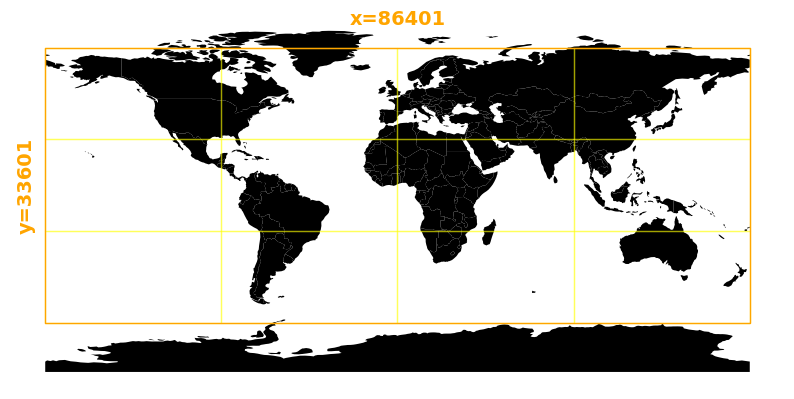

In [180]:
fig, ax = plt.subplots(figsize=(10,5))
world_map.plot(ax=ax, facecolor="black", edgecolor="none")
gpd.GeoSeries(tiles,crs=4326).plot(ax=ax, facecolor="none", edgecolor="yellow", alpha=.4)
gpd.GeoSeries([shapely.box(*geobox.boundingbox)],crs=4326).plot(ax=ax, facecolor="none", edgecolor="orange")

# Add dimension labels
# Get bounding box coordinates
minx, miny, maxx, maxy = geobox.boundingbox
# X dimension on top
ax.text((minx + maxx) / 2, maxy + 10, f'x={86401}', ha='center', va='bottom', fontsize=14, fontweight='bold', color='orange')
# Y dimension on left
ax.text(minx - 5, (miny + maxy) / 2, f'y={33601}', ha='right', va='center', rotation=90, fontsize=14, fontweight='bold', color='orange')


ax.axis('off')
fig.savefig("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/output/figures/misc/extent.png",bbox_inches='tight',dpi=300)

# Data Quality

In [129]:
modis = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/MODIS/Daily/1KM/processed/stage_2/modis_timeseries_reprojected.zarr", consolidated = False)
modis = modis.rio.write_crs(4326)
avhrr = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/glass/LST/AVHRR/0.05D/processed/stage_2/avhrr_timeseries_reprojected.zarr", consolidated = False)
avhrr = avhrr.rio.write_crs(4326)
viirs = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/eog/viirs/processed/stage_2/viirs_annual_timeseries_reprojected.zarr", consolidated = False)
viirs = viirs.rio.write_crs(4326)
ntl_harm = xr.open_zarr("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/ntl_harm/harmonized/processed/stage_2/ntl_harm_timeseries_reprojected.zarr",  consolidated = False)
ntl_harm = ntl_harm.rio.write_crs(4326)

subset_box = riyadh = (46.3, 23.5, 47.5, 25.1) # heat island visible in cross section, small and negative coef

modis_subset = modis["median"].sel(time="2012-12-31").rio.clip_box(*riyadh).compute().ffill(dim="latitude")
avhrr_subset = avhrr["median"].sel(time="2012-12-31").rio.clip_box(*riyadh).compute()
viirs_subset = viirs.viirs_annual.sel(time="2012-12-31").rio.clip_box(*riyadh).compute()
ntl_harm_subset = ntl_harm.ntl_harm.sel(time="2012-12-31").rio.clip_box(*riyadh).compute()

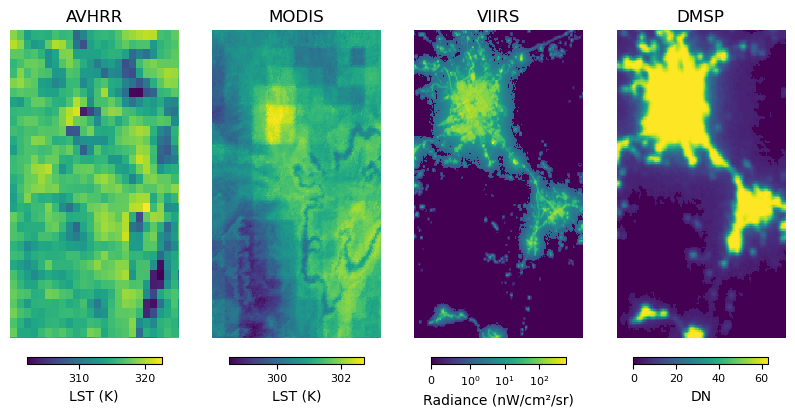

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(10,5))

modis_subset.squeeze().plot.imshow(ax=ax[1], add_colorbar=False)
avhrr_subset.squeeze().plot.imshow(ax=ax[0], add_colorbar=False)


# Set linthresh to a value that defines the linear region (e.g., 1 for small radiance values)
norm = SymLogNorm(linthresh=1, vmin=0, vmax=viirs_subset.max())  # Adjust vmax if needed to cap extremes

(viirs_subset+ 1e-10).squeeze().plot.imshow(ax=ax[2], add_colorbar=False, norm=norm)
ntl_harm_subset.squeeze().plot.imshow(ax=ax[3], add_colorbar=False)

for axs in ax:
    axs.axis('off')
    
ax[0].set_title('AVHRR')
ax[1].set_title('MODIS')
ax[2].set_title('VIIRS')
ax[3].set_title('DMSP')

# Add horizontal colorbars below each subplot
for i, axs in enumerate(ax):
    cbar = fig.colorbar(axs.images[0], ax=axs, orientation='horizontal', shrink=0.8, aspect=20, pad=0.05)
    cbar.ax.tick_params(labelsize=8)
    if i in [0, 1]:  # AVHRR and MODIS are LST
        cbar.set_label('LST (K)', fontsize=10)
    elif i == 2:  # VIIRS is radiance
        cbar.set_label('Radiance (nW/cm²/sr)', fontsize=10)
    else:  # DMSP is DN
        cbar.set_label('DN', fontsize=10)
        
fig.savefig("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/output/figures/misc/data_quality.png",bbox_inches='tight',dpi=300)

---
# Instruments

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from itertools import product
from odc.geo import CRS
from odc.geo.xr import xr_reproject
import imageio.v2 as imageio  # Updated to use imageio.v2 to avoid deprecation warning

In [25]:
input_path = "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/berman_mining/raw/baseline/BCRT_baseline.dta"
gif_output_path = "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/output/figures/misc/mining.gif"
start_year, end_year = [2000, 2010]
variables = ["nb_mines_a", "nb_diamond"]

# Load mining data
mines = pd.read_stata(input_path)


# Create xarray dataset
mines_ds = xr.Dataset.from_dataframe(
    mines.set_index(["year", "latitude", "longitude"])[variables]
)

# Set CRS
mines_ds = mines_ds.rio.write_crs(4326)

vmin, vmax = [mines_ds.nb_mines_a.min().values, mines_ds.nb_mines_a.max().values]

In [30]:
# List to hold frame images
frames = []

# pseudo-log color scale (SymLog handles zeros/small values)
norm = colors.SymLogNorm(linthresh=1, linscale=1, vmin=vmin, vmax=vmax)

for year in range(start_year, end_year + 1):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Select year
    mines_year_ds = mines_ds.sel(year=year)
    
    # Plot with pseudo-log normalization
    im = mines_year_ds.nb_mines_a.plot.imshow(
        ax=ax, cmap='viridis', norm=norm, add_colorbar=False, vmin=vmin, vmax=vmax
    )
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.8, aspect=20, pad=0.05)
    cbar.set_label('Number of Mines', fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    
    # Set title
    ax.set_title(f'{year}', fontsize=14)
    ax.axis('off')
    
    # Save frame
    frame_path = f'/tmp/frame_{year}.png'
    fig.savefig(frame_path, dpi=300, bbox_inches='tight')
    frames.append(imageio.imread(frame_path))
    plt.close(fig)
    os.remove(frame_path)

In [31]:
with imageio.get_writer(gif_output_path, mode='I', duration=1, fps=2, loop=0) as writer:
    for frame in frames:
        writer.append_data(frame)

In [ ]:
# Input paths
input_path = "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/plad/raw/PLAD_April_2024.dta"
adm_1_path = "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/misc/processed/stage_1/gadm/gadm_levelADM_1_simplified.gpkg"
gif_output_path = "/scicore/home/meiera/schulz0022/projects/growth-and-temperature/output/figures/misc/plad_favoritism.gif"
start_year, end_year = [2000, 2010]

# Load PLAD data - it's a whitespace-delimited file despite .dta extension
plad = pd.read_table(input_path)

# Load administrative boundaries
adm_gdf = gpd.read_file(adm_1_path)
adm_gdf["geometry"] = adm_gdf["geometry"].simplify(.1, preserve_topology=False)
gid_col = "GID_1"

# Create years to process
years_to_process = list(range(start_year, end_year + 1))

# Create administrative panel
adm_panel = pd.DataFrame(
    list(product(adm_gdf[gid_col].unique(), years_to_process)),
    columns=[gid_col, "year"]
)

# Merge with geometry
adm_panel = pd.merge(adm_panel, adm_gdf[[gid_col, "geometry"]])

# Create PLAD panel
plad_panel = pd.DataFrame(
    list(product(plad.gid_0.unique(), years_to_process)),
    columns=["gid_0", "year"]
)

# Process PLAD data to identify regional favoritism
def processor(row):
    """Find regions with favoritism for a given country-year."""
    qresults = plad.loc[
        (plad.startyear <= row["year"]) & 
        (plad.endyear >= row["year"]) & 
        (plad.gid_0 == row["gid_0"]),
        ["gid_1", "gid_2"]
    ]
    if qresults.empty:
        return pd.Series()
    else:
        return qresults.iloc[0]

plad_panel[["reg_fav_adm_1", "reg_fav_adm_2"]] = plad_panel.apply(processor, axis=1)

# Merge PLAD panel with administrative panel
reg_fav_panel = pd.merge(
    adm_panel, plad_panel,
    left_on=[gid_col, "year"],
    right_on=["reg_fav_adm_1", "year"],
    how="left"
)

# Create boolean regional favoritism indicator
reg_fav_panel["reg_fav"] = (~reg_fav_panel["reg_fav_adm_1"].isna()).astype(int)

# Clean up columns
columns_to_drop = ["gid_0", "reg_fav_adm_1", "reg_fav_adm_2"]
reg_fav_panel = reg_fav_panel.drop(columns=[col for col in columns_to_drop if col in reg_fav_panel.columns])

# Convert to GeoDataFrame
panel_gdf = gpd.GeoDataFrame(reg_fav_panel, crs=adm_gdf.crs)


In [24]:
# List to hold frame images
frames = []

for year in years_to_process:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Filter data for current year
    year_data = panel_gdf[panel_gdf['year'] == year]
    
    # Plot with regional favoritism indicator
    year_data.plot(
        column='reg_fav',
        ax=ax,
        legend=False,
        edgecolor='black',
        linewidth=0.5
    )
    
    # Set title
    ax.set_title(f'{year}', fontsize=14)
    ax.axis('off')
    
    # Save frame
    frame_path = f'/tmp/frame_{year}.png'
    fig.savefig(frame_path, dpi=300, bbox_inches='tight')  # Reduced DPI for faster processing
    frames.append(imageio.imread(frame_path))
    plt.close(fig)
    os.remove(frame_path)

# Create GIF
with imageio.get_writer(gif_output_path, mode='I', duration=0.5, fps=2, loop=0) as writer:
    for frame in frames:
        writer.append_data(frame)

---
# Heatmaps

In [ ]:
import numpy as np
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
from matplotlib.colors import Normalize

def compute_joint_density(ddf, x_col, y_col,
                          x_max, y_max, x_step, y_step,
                          min_x=0.0, min_y=0.0,
                          normalize=True, token="joint_heatmap"):
    """
    Compute per-bin counts for a 2D histogram (joint density) on a Dask DataFrame `ddf`
    using ddf.reduction without a finalize step. Returns a Dask object; call .compute()
    to get a pandas DataFrame with columns: bin_id, ix, iy, count, and optionally density.

    NOTE: Rows with NaN or inf values in x_col or y_col are dropped.
    """
    nx = int(np.ceil((x_max - min_x) / x_step))
    ny = int(np.ceil((y_max - min_y) / y_step))

    # Clean and filter
    ddf_clean = ddf[[x_col, y_col]].dropna()
    ddf_clean = ddf_clean[
        (ddf_clean[x_col].isna() == False) &
        (ddf_clean[y_col].isna() == False) &
        (np.isfinite(ddf_clean[x_col])) &
        (np.isfinite(ddf_clean[y_col]))
    ]

    # Compute integer bin indices lazily
    ix = ((ddf_clean[x_col] - min_x) / x_step).astype("int64").clip(0, nx - 1)
    iy = ((ddf_clean[y_col] - min_y) / y_step).astype("int64").clip(0, ny - 1)
    bin_id = ix * ny + iy
    ddf2 = ddf_clean.assign(__bin_id=bin_id)

    # Per-partition count by bin
    def _chunk(pdf):
        if pdf.empty:
            return pd.DataFrame(columns=["__bin_id", "count"]).astype({"__bin_id": "int64", "count": "int64"})
        g = pdf.groupby("__bin_id", sort=False).size()
        out = g.to_frame("count").reset_index()
        out["__bin_id"] = out["__bin_id"].astype("int64")
        out["count"] = out["count"].astype("int64")
        return out

    # Combine partials (tree combine)
    def _combine(parts_list):
        if not parts_list:
            return pd.DataFrame(columns=["__bin_id", "count"]).astype({"__bin_id": "int64", "count": "int64"})
        combined = pd.concat(parts_list, axis=0)
        combined = combined.groupby("__bin_id", sort=False)["count"].sum()
        out = combined.to_frame("count").reset_index()
        out["__bin_id"] = out["__bin_id"].astype("int64")
        out["count"] = out["count"].astype("int64")
        return out

    # Final aggregate returns the fully shaped dataframe (no finalize)
    def _agg(df):
        # Merge counts
        if df.empty:
            combined = pd.DataFrame(columns=["__bin_id", "count"]).astype({"__bin_id": "int64", "count": "int64"})
        else:
            df = df.groupby("__bin_id", sort=False)["count"].sum()
            combined = df.to_frame("count").reset_index()
            combined["__bin_id"] = combined["__bin_id"].astype("int64")
            combined["count"] = combined["count"].astype("int64")

        # Create full grid of bins and left-join, filling missing with zeros
        full_bins = pd.DataFrame({"__bin_id": np.arange(nx * ny, dtype="int64")})
        combined = full_bins.merge(combined, on="__bin_id", how="left").fillna(0)
        combined["count"] = combined["count"].astype("int64")

        # Compute ix, iy
        combined["ix"] = (combined["__bin_id"] // ny).astype("int64")
        combined["iy"] = (combined["__bin_id"] % ny).astype("int64")

        # Normalize if requested
        if normalize:
            total = combined["count"].sum()
            if total == 0:
                combined["density"] = 0.0
            else:
                combined["density"] = combined["count"] / float(total)

        combined = combined.rename(columns={"__bin_id": "bin_id"})
        cols = ["bin_id", "ix", "iy", "count"]
        if normalize:
            cols.append("density")
        # Ensure dtypes
        out = combined[cols].copy()
        out["bin_id"] = out["bin_id"].astype("int64")
        out["ix"] = out["ix"].astype("int64")
        out["iy"] = out["iy"].astype("int64")
        out["count"] = out["count"].astype("int64")
        if normalize:
            out["density"] = out["density"].astype("float64")
        return out

    # Meta matches the aggregate's final output schema
    meta_cols = ["bin_id", "ix", "iy", "count"]
    meta = pd.DataFrame(columns=meta_cols).astype(
        {"bin_id": "int64", "ix": "int64", "iy": "int64", "count": "int64"}
    )
    if normalize:
        meta["density"] = pd.Series(dtype="float64")

    stats_dd = ddf2.reduction(
        chunk=_chunk,
        aggregate=_agg,
        combine=_combine,
        meta=meta,
        token=token,
    )

    # Attach plotting metadata
    stats_dd._heatmap_meta = dict(nx=nx, ny=ny, min_x=min_x, min_y=min_y,
                                  x_step=x_step, y_step=y_step, normalize=normalize)
    return stats_dd

def _compute_shift_for_pseudolog(edges: np.ndarray, default_fraction: float = 1e-6) -> float:
    """Compute a small positive shift to move non-positive edges into (0, inf).
    Chooses a fraction of the (positive) step or uses a tiny absolute fallback.
    """
    # If there is any positive gap to use as scale, base shift on that
    positive = edges[edges > 0]
    if positive.size > 0:
        step_guess = np.min(np.diff(edges[edges > 0])) if edges.size > 1 else positive.min()
        base = max(step_guess, positive.min())
        return float(max(base * default_fraction, 1e-12))
    # fallback absolute tiny shift
    return float(default_fraction)

def plot_joint_density_from_stats(stats_df,
                                  nx, ny, min_x, min_y, x_step, y_step,
                                  value_col="density", cmap="viridis",
                                  figsize=(8, 6), vmin=None, vmax=None,
                                  x_scale="linear", y_scale="linear",
                                  color_norm: Optional[Normalize] = None):
    """
    Plot joint density using pcolormesh with support for:
      - x_scale / y_scale in {"linear", "log", "pseudolog"}
    "pseudolog" will add a tiny positive shift to bin edges so a log-scale axis
    can be used even when edges contain 0. The data itself is not re-binned;
    only the axis coordinates are shifted by a small epsilon.
    """
    # reconstruct array: arr[ix, iy] = value -> heat shape (ny, nx)
    arr = np.zeros((nx, ny), dtype=float)
    arr[stats_df["ix"].values, stats_df["iy"].values] = stats_df[value_col].values
    heat = arr.T  # shape (ny, nx): rows = y, cols = x

    x_edges = min_x + np.arange(nx + 1) * x_step
    y_edges = min_y + np.arange(ny + 1) * y_step

    valid_scales = ("linear", "log", "pseudolog")
    if x_scale not in valid_scales:
        raise ValueError("x_scale must be one of " + ", ".join(valid_scales))
    if y_scale not in valid_scales:
        raise ValueError("y_scale must be one of " + ", ".join(valid_scales))

    # handle pseudolog by shifting edges slightly positive when needed
    x_edges_plot = x_edges.copy()
    y_edges_plot = y_edges.copy()
    x_shift = 0.0
    y_shift = 0.0

    if x_scale in ("log", "pseudolog"):
        if np.any(x_edges <= 0):
            if x_scale == "log":
                raise ValueError("x_edges contain non-positive values; cannot use pure log scale for x")
            # pseudolog: compute small shift and apply
            x_shift = _compute_shift_for_pseudolog(x_edges)
            x_edges_plot = x_edges + x_shift
        # else: edges already positive, use log directly

    if y_scale in ("log", "pseudolog"):
        if np.any(y_edges <= 0):
            if y_scale == "log":
                raise ValueError("y_edges contain non-positive values; cannot use pure log scale for y")
            y_shift = _compute_shift_for_pseudolog(y_edges)
            y_edges_plot = y_edges + y_shift

    plt.figure(figsize=figsize)
    mesh = plt.pcolormesh(x_edges_plot, y_edges_plot, heat,
                          shading="auto", cmap=cmap, norm=color_norm,
                          vmin=vmin, vmax=vmax)

    ax = plt.gca()
    if x_scale in ("log", "pseudolog"):
        ax.set_xscale("log")
        if x_shift != 0.0:
            # annotate axis so user knows 0 was shifted
            ax.annotate("", xy=(0, 0), xytext=(0, 0))  # no-op to keep code short; user can add custom annotation
    if y_scale in ("log", "pseudolog"):
        ax.set_yscale("log")
        if y_shift != 0.0:
            pass  # placeholder if custom annotation is desired

    cbar = plt.colorbar(mesh, label=value_col)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Joint {value_col}")
    plt.tight_layout()

    # return mesh and shifts so caller can, if desired, add explanatory text/legend
    return mesh, dict(x_shift=x_shift, y_shift=y_shift)

# Example usage:

# Read the parquet file
ddf = dd.read_parquet("/scicore/home/meiera/schulz0022/projects/growth-and-temperature/data_nobackup/assembled/modis_subset.parquet")



# Compute joint density for median vs viirs_annual
stats_dd = compute_joint_density(
    ddf,
    x_col="median",
    y_col="viirs_annual",
    x_max=400,
    y_max=200,
    x_step=1,
    y_step=1,
    min_x=200,
    min_y=0,
    normalize=True,
)

# Trigger computation
with ProgressBar():
    stats = stats_dd.compute()

# Access metadata
meta = stats_dd._heatmap_meta

# Set linthresh to a value that defines the linear region (e.g., 1 for small radiance values)
norm = SymLogNorm(linthresh=1, vmin=0, vmax=200)  # Adjust vmax if needed to cap extremes


# Plot
im = plot_joint_density_from_stats(
    stats,
    meta["nx"],
    meta["ny"],
    meta["min_x"],
    meta["min_y"],
    meta["x_step"],
    meta["y_step"],
    value_col="density",
    cmap="viridis",
    y_scale = "pseudolog"
)
plt.xlabel("median")
plt.ylabel("viirs_annual")
plt.title("Joint Density: median vs viirs_annual")
plt.show()


[########################################] | 100% Completed | 1.78 ss


KeyError: 'density'